<a href="https://colab.research.google.com/github/Vortex-002/CNN/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hi! Welcome to my project.
> Here you will get to see that how write simple code in colab can make it possible to rule out skin diseases efficiently though this project is purely for educational purposes and should not be used to actually diagnose any disease.

>Every code block will have a text block preceding it to explain what happens in it.
> Link to the Dataset: https://www.kaggle.com/datasets/adityush/eczema2

# Calculating Mean and Standard Deviation

Here I am calculating the mean and standard deviation to rule out the normalizing facotrs which are mean and standard deviation for the normalising transform applied on the dataset.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data', transform=transform)


loader = DataLoader(dataset, batch_size=32, shuffle=False)


mean = 0.0
std = 0.0
total_images = 0


for images, _ in tqdm(loader, desc="Calculating mean and std", unit="batch"):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples


mean /= total_images
std /= total_images

print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')


# Dataloader Block
- I applied transforms to the images as in data augmentation to alter the image so that the model learns better
- I load the dataset
- I split the dataset with `random_spilt` in 80 10 10 format
- Then separated them into batches

In [4]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.6314, 0.5293, 0.4935], [0.1907, 0.1813, 0.1858])
])


dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data', transform=transform)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2956
Validation dataset size: 369
Test dataset size: 371


# THE MODEL

> This is the model architecture a detailed explanation of how it works is in: https://docs.google.com/document/d/1hQK2o809k89_jgKlYjPn3Y3VJqX87nfTIfLZN6BNaLo/edit?tab=t.0

> To sum it up briefly
-  3 convolutional layers (9-17)
-  LSTM (22)
-  Fully connected layers (25 - 27)
-  Forward function with: (29-46)
      - Feature extraction (31-33)
      - RNN reshaping
      - The actual RNN
      - FC + Dropout + Output

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)


        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)


        self.fc1 = nn.Linear(64 * 2, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))


        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(b, -1, c)


        x, _ = self.lstm(x)
        x = x[:, -1, :]


        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))

        return x


# The Train Block
> Here I declare the optimizer as SGD with momentum and also we take Binary Cross Entropy Loss for our loss function. I have kept number of epochs as 10.


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

num_epochs = 10
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.01


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

criterion = nn.BCELoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=100)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = train_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"\n Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

    torch.save(model, "cnn_model.pt")


#Comparison code
This section is purely for comparison with an optimiser as Adam

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


num_epochs = 10
learning_rate = 0.001
weight_decay = 0.01


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

criterion = nn.BCELoss()


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=100)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total
    print(f"\nEpoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")


    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%\n")


torch.save(model, "cnn_adam_model.pt")

# The Metrics Block
> Here we find out the:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - Specificity
  - ROC AUC
  - ROC Plot
  - Confusion Matrix

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/cnn_model.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()


def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > threshold).float().cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-6)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"ROC AUC     : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Eczema'], yticklabels=['Normal', 'Eczema'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


evaluate_model(model, val_loader)


# This is the test metrics code block
 - All I have done here is that I have evaluated the model based on the evaluation metrics used above but only for the test set.

Accuracy    : 0.8706
Precision   : 0.8808
Recall      : 0.8160
F1 Score    : 0.8471
Specificity : 0.9135
ROC AUC     : 0.9292


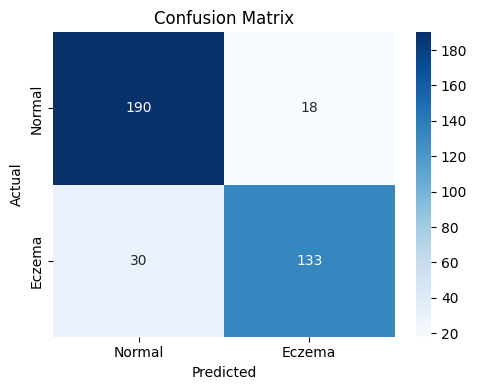

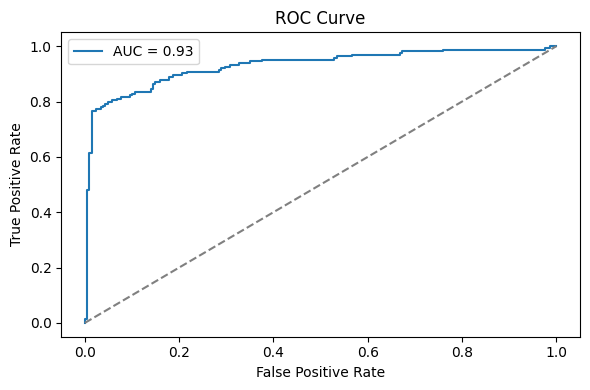

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/cnn_model.pt"
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()


def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs > threshold).float().cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-6)

    print(f"Accuracy    : {acc:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"ROC AUC     : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Eczema'], yticklabels=['Normal', 'Eczema'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


evaluate_model(model, test_loader)
